In [2]:
%pylab inline
import numpy as np
import findspark
findspark.init()
import sys
from pickle import load
from scipy.special import gammaln
from sklearn.decomposition import PCA
sys.path.append('./lib')
from numpy_pack import packArray,unpackArray
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot
from import_modules import import_modules,modules
import_modules(modules)
from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])
from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [27]:
sc.stop()

In [4]:
data_dir='../../Data/Weather'
file_index='SSSSBBBB'
meas='SNWD' # half of a year has no snow
meas='PRCP'

filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
df=df_in.filter(df_in.measurement==meas)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [5]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()

In [6]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)

All={}
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector
    
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [7]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00299657 356
USC00292810 365
US1NMSM0005 644
US1NMBR0053 360
US1NMSM0007 670
US1NMSM0006 1023
US1NMBR0056 2085
US1NMSM0002 331
USS0006P10S 6365
USC00292250 9747
USC00292315 3274
US1NMSN0035 1380
US1NMSN0033 662
USC00293781 364
US1NMSN0039 365
USC00290743 15183
USW00053003 725
USC00291028 1822
US1NMBR0062 348
USC00294684 1337
USC00293488 20682
USC00294369 34099
US1NMBR0119 339
USC00294366 3924
US1NMSM0010 323
USC00296913 730
USC00296912 1338
USC00296911 6086
US1NMBR0028 2530
USC00296693 1058
USC00296900 3602
USC00293374 1675
USC00298834 5448
US1NMSN0024 714
US1NMSN0026 1668
USC00295084 31494
USC00294141 694
USC00297918 6181
US1NMSN0028 1743
USS0005P04S 661
US1NMSF0006 704
USC00290222 4677
US1NMRA0022 1083
USC00290225 6926
USC00298524 16272
US1NMBR0034 2190
USC00298227 6136
US1NMBR0036 699
US1NMBR0037 2161
US1NMBR0032 1001
USC00295140 1017
USC00293678 2124
US1NMBR0051 355
US1NMSN0012 1088
USW00093057 17780
US1NMSN0014 331
US1NMSN0016 642
USC00299031 15869
USC00290765 3187
USC00296754 

In [8]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(186, 58035)


In [9]:
def G(n):
    return gammaln(n+1)

def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m

def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m

def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)
    
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

In [10]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

0 1

/Users/tak/anaconda/envs/CSE255/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


(34596,) (12948,)


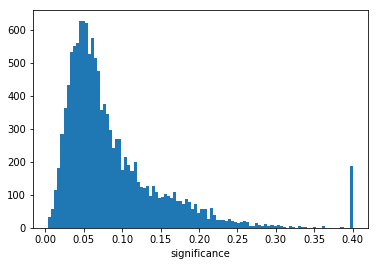

In [11]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

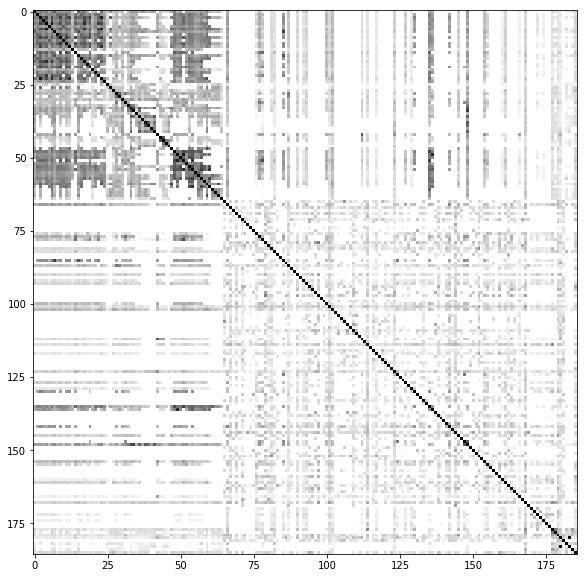

In [12]:
showmat(P_norm)

In [13]:
print 'A group of very correlated stations is:',All.keys()[:25]

A group of very correlated stations is: [u'USC00299657', u'USC00292810', u'US1NMSM0005', u'US1NMBR0053', u'US1NMSM0007', u'US1NMSM0006', u'US1NMBR0056', u'US1NMSM0002', u'USS0006P10S', u'USC00292250', u'USC00292315', u'US1NMSN0035', u'US1NMSN0033', u'USC00293781', u'US1NMSN0039', u'USC00290743', u'USW00053003', u'USC00291028', u'US1NMBR0062', u'USC00294684', u'USC00293488', u'USC00294369', u'US1NMBR0119', u'USC00294366', u'US1NMSM0010']


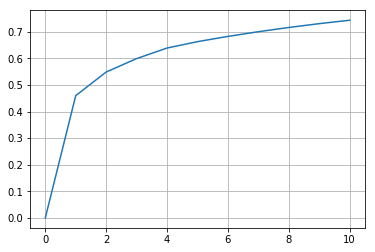

In [14]:
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [15]:
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

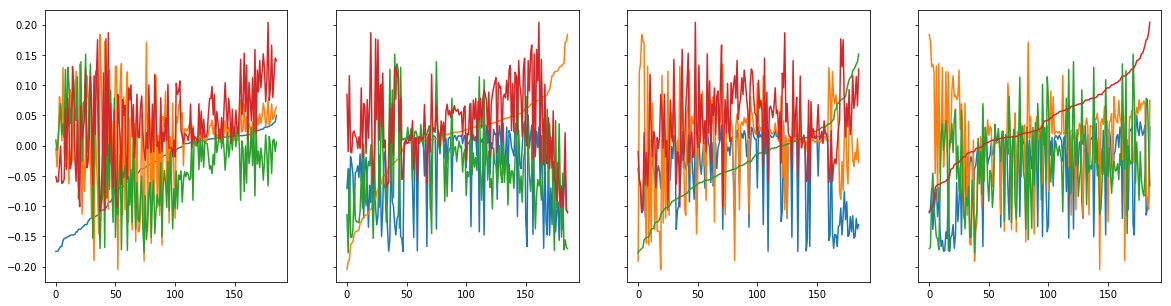

In [16]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

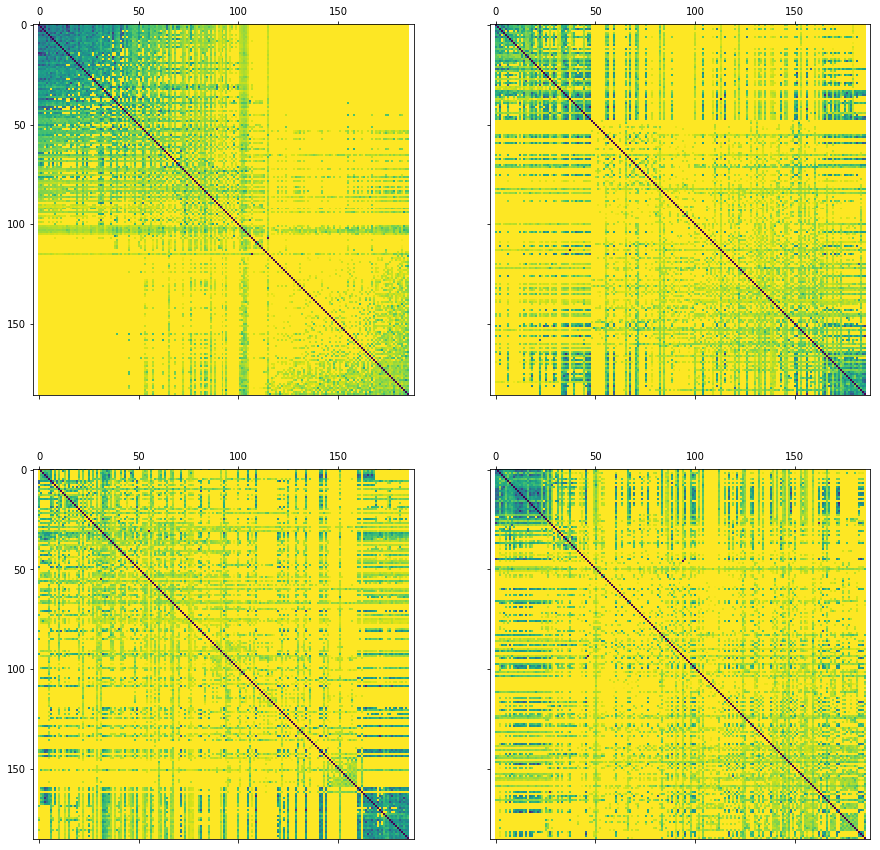

In [36]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

In [37]:
from pickle import dump
with open(data_dir+'/PRCP_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)